## 项目介绍
- 1 先讲解注意力机制理论知识，涉及到自注意力机制、多头注意力机制
- 2 讲解Encoder-Decoder（Seq2Seq）编码器-解码器理论原理
- 3 讲解Transformer原理
- 4 代码实现Transformer分类的模型-Vision Transformer (ViT)

## 1 attention(注意力机制)
- **定义：**

注意力机制（Attention Mechanism）是机器学习中的一种数据处理方法，广泛应用在自然语言处理、图像识别及语音识别等各种不同类型的机器学习任务中。

- **意义：**

注意力这个词本来是属于人类才有的动作。也就是说，注意力机制可以看做是一种仿生，是机器通过对人类阅读、听说中的注意力行为进行模拟。那为何要对注意力进行仿生，按理说，计算机理应拥有无限的记忆力和注意力。这是因为，人脑在进行阅读任务、读图任务时，并不是严格的解码过程，而是接近于一种模式识别。大脑会自动忽略低可能、低价值的信息。如果计算机不能模拟人类的注意力状态，就可能让无关的信息对处理结果造成干扰，最后导致处理结果偏离实际的应用场景。为了让计算机更加适应人类交流场景，必须教会计算机选择遗忘和关联上下文，这种机制就是所谓的注意力机制。

- **公式：**（看见公式莫慌，看完下面的描述再回看）

Google 2017年论文中，Attention Is All You Need曾经为Attention做了一个抽象定义：

> Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V

注意力是将一个查询和键值对映射到输出的方法，Q、K、V均为向量，输出通过对V进行加权求和得到，权重就是Q、K相似度。

- **图形化解释**

典型的attention包含Q K V三部分：Q是Quer指代输入的信息，Key和Value成组出现，通常是源语言、原始文本等已有的信息。通过计算Q与K的相关性（矩阵的知识，相关性计算下面讲述两种处理方式），得出不同的K对输出的重要程度，再与对应的V相乘求和，所得到的输出attention的值。（如下图所示）
![](https://ai-studio-static-online.cdn.bcebos.com/4133357ab111406f8a25f7af1b7507614c691836a5d0498cb944b3fe3e3f5558)

看到这，大家也许开始产生一些疑问，究竟上图中的a值（即Q与K的相关性）是如何计算的呢，下面我将讲解两种方式：Dot-product、Additive

- Dot-product：两个输入的向量分别乘Wq和Wk矩阵（这俩矩阵是随机生成的，通过后续的不断迭代学习进行更新），得到q和k，再做点乘运算得到q与k的相关性a值。如下图所示

![](https://ai-studio-static-online.cdn.bcebos.com/e6892edb8f4f4da080a3856c3b35209a80a4be1560aa41008afeb766f4d168a3)

- Additive：两个输入的向量分别乘Wq和Wk矩阵，得到q和k，再串起来，过tanh激活函数，再乘W矩阵，得到q与k的相关性a值。如下图所示

![](https://ai-studio-static-online.cdn.bcebos.com/8a85a0efd41844a68ef4e4e5fe6d0e4b24ed6e89a41848c2aadec21173829f3a)

- 小结：得到a值（即Q与K的相关性）的方法不唯一，Transformer采用的是第一种方式Dot-product 

### 1.1 self-attention(自注意力机制)

- a1.1表示a1本身的相关性，a1.2表示a1和a2的相关性以此类推，最后再过softmax函数（也可以用其它的激活函数），得到最终相关性值

![](https://ai-studio-static-online.cdn.bcebos.com/510a61dd425a4b5c8ea6d0dd9d3cf455dedcb131177f4fd7a1230c3f300229bc)

- 将刚刚得到的相关性值与v相乘，再求和，得到attention的值b1。可以发现谁的相关性越大，则给与它V值的权重越大。

![](https://ai-studio-static-online.cdn.bcebos.com/d45e85245d72473a960f1ccfaa61e4c55ac7914254f04305ab521bbd811a6391)

- 步骤同上，得出一系列attention的值,例如b2。

![](https://ai-studio-static-online.cdn.bcebos.com/23ec31001792494486cbc6c15e597d6ecb6c02ed9f904af7a93d2d84d7d563d9)

- 用矩阵的方式，实现并行运算，复述上述步骤。a1到a4表示4个输入，通过Wq、Wk、Wv矩阵（这3矩阵起初是随机生成，通过不断学习进行迭代更新）相乘，分别得到q、k、v的一维矩阵。

![](https://ai-studio-static-online.cdn.bcebos.com/6c875371bae64a78a82fd47521019684835bbafefa024087bc2b5beff42b2b57)

- q、k一维矩阵（此处为k的转置）相乘，得到相关性的矩阵，这个矩阵整体过softmax得到最终的相关性矩阵

![](https://ai-studio-static-online.cdn.bcebos.com/3884bf28435647d28fbc8fb0e850c64fe05c834a3c884516970a1224a08e8cdc)

- v乘相关性矩阵，得到最终的attention值的矩阵。至此self-attention结束。

![](https://ai-studio-static-online.cdn.bcebos.com/a2a1a24c671241c99ef8d5ad4d2fe8a756e7ebedd8d945a3831cb12614c799a3)

### 1.2 multi-attention(多头注意力机制)

- 了解self-attention后，multi-attention就简单了许多（以2头注意力机制举例子），同self-attention得到qi，再在qi的基础上分别乘Wq1、Wq2（随机生成，后续学习更新）矩阵得到qi.1、qi.2，同理得到 ki.1、ki.2、vi.1、vi.2，图1所示，同理另一个输入也做上述操作，图2所示

![](https://ai-studio-static-online.cdn.bcebos.com/11fa4348a5124ab78138170dee7c5c82caf71d377c0441989d2ec2c6ab08c3c2)

![](https://ai-studio-static-online.cdn.bcebos.com/1479dec7e71840929e04845533b9a992d61d1009165746eea26c004cbd2a3ffc)

- q、k做相关性计算，（点后面数相同为组，即?.1为一组），分别得到bi.1、bi.2，图1、2，再通过矩阵Wo（随机生成的，后续学习更新）得到bi，图3，余下的操作就跟self-attention一样了，至此multi-attention结束

![](https://ai-studio-static-online.cdn.bcebos.com/9e0655ee13a64c19bbe715421d8b2297564a00459b814d70893c365d2916580f)

![](https://ai-studio-static-online.cdn.bcebos.com/217df24fc610435b97e85c4c02453f26daee15e8d0a8403c80de130eec4e3799)

![](https://ai-studio-static-online.cdn.bcebos.com/8ddbef125a624602a3d33a9f4b964b0609342e40099242b9a5511135e036d024)

### 1.3 回看
- 现在大家回看这个公式是不是清晰了许多  
> Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V

![](https://ai-studio-static-online.cdn.bcebos.com/c96bbd2032064b4186f8a724be9f1349971521bbfc0f4b00a87a7863c3870a89)

- 是不是在疑问为什么要除根号下dk，因为q、k相乘（相关性计算）值很大，softmax反向传播梯度很小（看下softmax的公式就悟了），除根号下dk可以避免梯度消失
- 为什么除根号下dk不除其它呢,为了保持方差为1。
- 至此Attention讲解完毕，还有不明白同学，欢迎评论区提问，我会不定时的为大家讲解问题。

## 2 Encoder-Decoder（Seq2Seq）编码器-解码器
- 原始RNN只能N->1、1->N、N->N，然而我们遇到的大部分问题序列都是不等长的，N->M，如机器翻译中，源语言和目标语言的句子往往并没有相同的长度。
- Encoder-Decoder结构先将输入数据编码成一个上下文向量c：得到c有多种方式，最简单的方法就是把Encoder的最后一个隐状态赋值给c，还可以对最后的隐状态做一个变换得到c，也可以对所有的隐状态做变换。

![](https://ai-studio-static-online.cdn.bcebos.com/1d5a81f14af744379f3f941baff01b37e436b6107aa14f45a9bb1a2fd326d1d9)

- 拿到c之后，就用另一个RNN网络对其进行解码，这部分RNN网络被称为Decoder。具体做法就是将c当做之前的初始状态h0输入到Decoder中：

![](https://ai-studio-static-online.cdn.bcebos.com/812584a6e23a4cc5b2717737dd95c77339aa152775ca4b4abf9459c60e5acdb1)

- 还有一种做法是将c当做每一步的输入：由于这种Encoder-Decoder结构不限制输入和输出的序列长度，因此应用的范围非常广泛

![](https://ai-studio-static-online.cdn.bcebos.com/d2459dadb0854008aab28844ff1a66d5ea1607eee3514d05bc604f13a5f754bc)


## 3 Transformer

### 3.1 全局角度
- Transformer原论文《transformer is all you need》，包含6个Encoder和Decoder结构（这6个Encoder或Decoder，之间结构相同，参数不同）

![](https://ai-studio-static-online.cdn.bcebos.com/05ad0600909549cbb3674b214919f7126b0f622782c34130958fb4b6503b7b92)

- 拿出一对Encoder和Decoder结构作为讲解，大家先熟悉一下整体架构，下面会逐层讲解

![](https://ai-studio-static-online.cdn.bcebos.com/e42c35e54d214c469662fb01c99ee1029c104be009a34571a7384535369c369f)

### 3.2 Encoder

**分为3个部分**
- 输入部分：Embedding+位置嵌入
- 注意力机制：上述已说明，此处用的是multi-attention(多头注意力机制)
- 前馈神经网络：包含两层全连接

![](https://ai-studio-static-online.cdn.bcebos.com/6b51044fe8bf44d5ae3b0b722b5deea55bb81f6726214699a5637e32a5f06fd1)

### 3.3 残差和LN（Layer Normal）取代BN（Batch Normal）

- 残差（虚线标记的地方）：防止因梯度消失造成的信息丢失，绿框和红框表示梯度连乘（造成梯度消失的主要原因），公式最后，即使红框中的梯度消失，前面还有个‘1’，就不会造成信息的丢失。

![](https://ai-studio-static-online.cdn.bcebos.com/7b34dc37a7ad45caa9c2e314a6b011c751c048582d974c95b299ddcc1879728d)

- LN（Layer Normal）取代BN（Batch Normal）：BN操作存在弊端，如果batch较小，不足以代表全部样本，效果差。下面是整体结构图。（对应Transformer图片中应为multi-attention(多头注意力机制)，不是self-attention）

![](https://ai-studio-static-online.cdn.bcebos.com/64203196b578490f85dc039f80cf5de73da907ea81544bf38c28467875af9f85)

### 3.4 Decoder

![](https://ai-studio-static-online.cdn.bcebos.com/81180f2113894b6289141ac8668ab2791ab6232a8be548f0a70d75f7f7bad022)

- 红框1：mask操作，是对当前单词和之后的单词做mask操作（NLP中的操作）因为是预测后面的词，所以不能让网络看见后面的词
- 红框2：进入Decoder的两条数据，是由Encoder产生的k、v，Decoder只提供q。

![](https://ai-studio-static-online.cdn.bcebos.com/516a2a2fd66445a0ad8d977bb642f39e2be93f971297491099e72c251d9592fc)



## 4 Vision Transformer (ViT)
- ViT（vision transformer）是Google在2020年提出的直接将transformer应用在图像分类的模型，后面很多的工作都是基于ViT进行改进的。
- ViT的思路很简单：

直接把图像分成固定大小的patchs，然后通过线性变换得到patch embedding，这就类比NLP的words和word embedding，由于transformer的输入就是a sequence of token embeddings，所以将图像的patch embeddings送入transformer后就能够进行特征提取从而分类了。
- ViT模型原理如下图所示，其实ViT模型只是用了transformer的Encoder来提取特征（原始的transformer还有decoder部分，用于实现sequence to sequence，比如机器翻译）。
- 操作步骤

图片分块，展开，做线性变换（形成与时间序列一致的输入）

在块序列首位置添加虚拟开始块，用作后续的图像分类特征

使用Transformer-Encoder进行块编码

虚拟块表示作为分类向量，通过MLP进行分类

![](https://ai-studio-static-online.cdn.bcebos.com/8ca3c1d456f84bcfb813644575fe810e888d95d3bb3b4b32bba3baf0b3f61709)


## 5 代码实现
利用飞桨框架搭建一个Vision Transformer模型，包含不同车辆的图像进行分类。标签值说明：1=“汽车”'，2=“摩托车”，3=“货车”。

### 5.1 导入相关包

In [1]:
import os
import zipfile
import random
import paddle
from paddle import fluid
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from paddle.io import Dataset 
import numpy as np 
import sys
import paddle.nn as nn
from multiprocessing import cpu_count  
from paddle.nn import MaxPool2D,Conv2D,BatchNorm2D
from paddle.nn import Linear 
import random
from paddle.nn.initializer import TruncatedNormal, Constant 
from paddle.nn import TransformerEncoderLayer, TransformerEncoder
from paddle.regularizer import L2Decay

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


### 5.2 配置模型超参数

In [2]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 120, 120],                             #输入图片的shape
    "class_dim": 3,                                          #分类数
    "src_path":"/home/aistudio/data/data93289/Data.zip",     #原始数据集路径
    "target_path":"/home/aistudio/work/",                    #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",      #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",        #eval.txt路径
    "label_dict":{'0':'汽车','1':'摩托车','2':'货车'},        #标签字典
    "num_epochs": 40,                                        #训练轮数
    "train_batch_size": 32,                                   #训练时每个批次的大小
    "learning_strategy": {                                   #优化函数相关的配置
        "lr": 1.0e-5                                        #超参数学习率
    }, 
    'skip_steps': 50,                                        #每N个批次打印一次结果
    'save_steps': 500,                                       #每N个批次保存一次模型参数
    "checkpoints": "/home/aistudio/work/checkpoints"         #保存的路径

}

def seed_paddle(seed=1024):
    seed = int(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    paddle.seed(seed)

seed_paddle(seed=1024)

### 5.3 数据集准备
(1)解压原始数据集，查看数据

(2)按照比例划分训练集与验证集

(3)乱序，生成数据列表

(4)定义数据读取器

In [3]:
# 解压原始数据集
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(os.path.join(target_path,'Data'))):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
        print('数据集解压完成')
    else:
        print('文件已存在')

def get_data_list(target_path, train_list_path, eval_list_path):
    '''
    生成数据列表
    '''
    data_dir = 'work/Data'
    all_data_list  = []

    for im in os.listdir(data_dir):
        img_path = os.path.join(data_dir, im)
        img_label = str(int(im.split('_')[0])-1)
        all_data_list.append(img_path + '\t' + img_label + '\n')


    # 对训练列表进行乱序
    random.shuffle(all_data_list)
    
    with open(train_list_path, 'a') as f1:
        with open(eval_list_path, 'a') as f2:
            for ind, img_path_label in enumerate(all_data_list):
                #划分测试集和训练集
                if ind % 10 == 0:
                    f2.write(img_path_label) 
                else:
                    f1.write(img_path_label)
    print ('生成数据列表完成！')

class dataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [7]:
#参数初始化
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

#解压原始数据到指定路径
unzip_data(src_path,target_path)

文件已存在


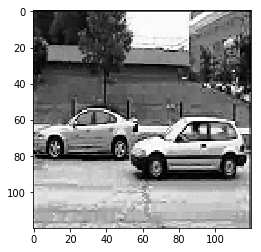

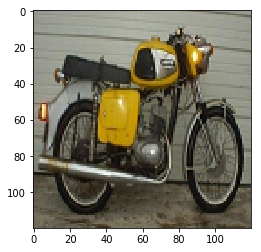

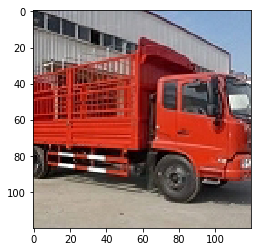

In [5]:
#查看数据
path1='/home/aistudio/work/Data/1_96.png'
path2='/home/aistudio/work/Data/2_832.png'
path3='/home/aistudio/work/Data/3_1398.png'
# 汽车
img1 = Image.open(path1)
plt.imshow(img1)          #根据数组绘制图像
plt.show()
# 摩托车
img2 = Image.open(path2)
plt.imshow(img2)          #根据数组绘制图像
plt.show()               #显示图像
# 货车
img3 = Image.open(path3)
plt.imshow(img3)          #根据数组绘制图像
plt.show()               #显示图像

In [8]:
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate()     

#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

#训练数据加载
train_dataset = dataset('/home/aistudio/data',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, 
                                    batch_size=train_parameters['train_batch_size'], 
                                    shuffle=True
                                    )
#测试数据加载
eval_dataset = dataset('/home/aistudio/data',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset,
                                   batch_size=train_parameters['train_batch_size'], 
                                   shuffle=False
                                   )

生成数据列表完成！


### 5.4 构建Vision Transformer模型

In [5]:
# 定义ViT
trunc_normal_ = TruncatedNormal(std=.02)
zeros_ = Constant(value=0.)
ones_ = Constant(value=1.)
dim =256
heads=16
patch_size = 8
num_layers = 3
num_patch = int((120/patch_size) * (120/patch_size))

# x[int] -> tuple(x, x)
def to_2tuple(x):
    return tuple([x] * 2)

# 独立层，即什么操作都没有的网络层
class Identity(nn.Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, input):
        return input

class PatchEmbed(nn.Layer):
    def __init__(self, img_size=120, patch_size=patch_size, in_chans=3, embed_dim=dim):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * \
            (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2D(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # 分块线性变换 + 向量展平 + 维度转置
        x = self.proj(x).flatten(2).transpose((0, 2, 1))
        return x

class Attention(nn.Layer):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias_attr=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape

        # 线性变换
        qkv = self.qkv(x).reshape((B, N, 3, self.num_heads, C //
                                   self.num_heads)).transpose((2, 0, 3, 1, 4))
        
        # 分割 query key value
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Matmul + Scale
        attn = (q.matmul(k.transpose((0, 1, 3, 2)))) * self.scale

        # SoftMax
        attn = nn.functional.softmax(attn, axis=-1)
        
        # Attention Dropout
        attn = self.attn_drop(attn)
        
        # Matmul
        x = (attn.matmul(v)).transpose((0, 2, 1, 3)).reshape((B, N, C))

        # 线性变换
        x = self.proj(x)

        # Linear Dropout
        x = self.proj_drop(x)
        return x

class Mlp(nn.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x): 
        x = self.fc1(x) 
        x = self.act(x) 
        x = self.drop(x) 
        x = self.fc2(x) 
        x = self.drop(x)
        return x

def drop_path(x, drop_prob=0., training=False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = paddle.to_tensor(1 - drop_prob)
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + paddle.rand(shape, dtype=x.dtype)
    random_tensor = paddle.floor(random_tensor) # binarize
    output = x.divide(keep_prob) * random_tensor
    return output


class DropPath(nn.Layer):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


# Block类实现Transformer encoder的一个层
class Block(nn.Layer):
    # 定义Transformer层
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer='nn.LayerNorm', epsilon=1e-5):
        super().__init__()
        # 此处添加代码
        self.norml = eval(norm_layer)(dim, epsilon=epsilon)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )
        
        self.drop_path = DropPath(drop_path) if drop_path > 0. else Identity()
        self.norm2 = eval(norm_layer)(dim, epsilon=epsilon)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norml(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Layer):
    def __init__(self, img_size=120, patch_size=patch_size, in_chans=3, class_dim=train_parameters['class_dim'], embed_dim=dim, depth=num_layers,
                 num_heads=heads, mlp_ratio=4, qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer='nn.LayerNorm', epsilon=1e-5, **args):
        super().__init__()
        self.class_dim = class_dim

        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.pos_embed = self.create_parameter(
            shape=(1, num_patches + 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("pos_embed", self.pos_embed)
        self.cls_token = self.create_parameter(
            shape=(1, 1, embed_dim), default_initializer=zeros_)
        self.add_parameter("cls_token", self.cls_token)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x for x in paddle.linspace(0, drop_path_rate, depth)]

        self.blocks = nn.LayerList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, epsilon=epsilon)
            for i in range(depth)])

        self.norm = eval(norm_layer)(embed_dim, epsilon=epsilon)

        # Classifier head
        self.head = nn.Linear(
            embed_dim, class_dim) if class_dim > 0 else Identity()

        trunc_normal_(self.pos_embed)
        trunc_normal_(self.cls_token)
        self.apply(self._init_weights)
    
    # 参数初始化
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            zeros_(m.bias)
            ones_(m.weight)
    
    # 获取图像特征
    def forward_features(self, x):
        B = x.shape[0] 
        # Image Patch Embedding
        x = self.patch_embed(x) 
        # 分类 tokens
        cls_tokens = self.cls_token.expand((B, -1, -1)) 
        # 拼接 Embedding 和 分类 tokens
        x = paddle.concat((cls_tokens, x), axis=1) 
        # 加入位置嵌入 Position Embedding
        x = x + self.pos_embed 
        # Embedding Dropout
        x = self.pos_drop(x)
        # Transformer Encoder
        # 由多个基础模块组成
        for blk in self.blocks:
            x = blk(x) 
        # Norm
        x = self.norm(x) 
        # 提取分类 tokens 的输出
        return x[:, 0]
    
    def forward(self, x):
        x = paddle.reshape(x, shape=[-1, 3,120,120])
        # 获取图像特征
        x = self.forward_features(x) 
        # 图像分类 
        x = self.head(x) 
        return x

### 5.5 训练模型

In [6]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

epo: 1, step: 50, loss is: [1.0511264], acc is: [0.375]
epo: 2, step: 100, loss is: [1.0749162], acc is: [0.375]
epo: 3, step: 150, loss is: [0.88865685], acc is: [0.65625]
epo: 4, step: 200, loss is: [0.5504421], acc is: [0.78125]
epo: 5, step: 250, loss is: [0.48934796], acc is: [0.8125]
epo: 6, step: 300, loss is: [0.2699679], acc is: [0.875]
epo: 7, step: 350, loss is: [0.11708505], acc is: [0.9375]
epo: 8, step: 400, loss is: [0.22028327], acc is: [0.90625]
epo: 9, step: 450, loss is: [0.28658137], acc is: [0.8333333]
epo: 11, step: 500, loss is: [0.07324414], acc is: [0.96875]
save model to: /home/aistudio/work/checkpoints/save_dir_500.pdparams
epo: 12, step: 550, loss is: [0.04826813], acc is: [1.]
epo: 13, step: 600, loss is: [0.01948055], acc is: [1.]
epo: 14, step: 650, loss is: [0.03476083], acc is: [1.]
epo: 15, step: 700, loss is: [0.02033299], acc is: [1.]
epo: 16, step: 750, loss is: [0.19120577], acc is: [0.9375]
epo: 17, step: 800, loss is: [0.10908449], acc is: [0.937

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


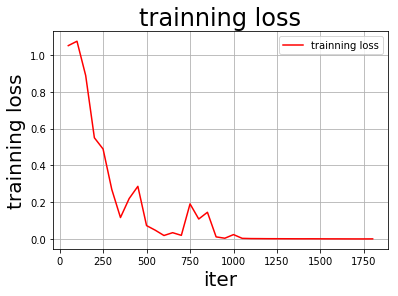

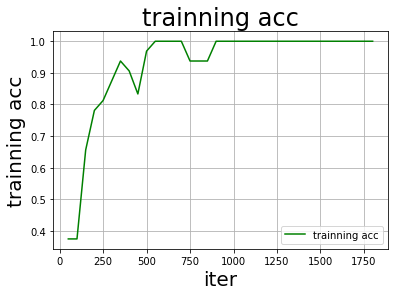

In [7]:
model = VisionTransformer()
model.train()
cross_entropy = paddle.nn.CrossEntropyLoss()
optimizer = paddle.optimizer.Adam(learning_rate=0.0001, parameters=model.parameters()) 
                                  
steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(train_parameters['num_epochs']):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        loss = cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))
        #保存模型参数
        if steps % train_parameters["save_steps"] == 0:
            save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + str(steps) + '.pdparams'
            print('save model to: ' + save_path)
            paddle.save(model.state_dict(),save_path)
paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

### 5.6 评估模型

In [8]:
'''
模型评估
'''
model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_eval = VisionTransformer()
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()

accs = []
for _, data in enumerate(eval_loader()):
    x_data = data[0]
    y_data = data[1]
    predicts = model_eval(x_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    accs.append(acc.numpy()[0])
print('模型在验证集上的准确率为：',np.mean(accs))

模型在验证集上的准确率为： 0.8416667


## 小结
> - 以上是作者平时学习做的项目笔记，不同见解欢迎各位大佬指正，大家也可以尝试换数据集，原理相同的，后续作者进军transformer目标检测-DETR
> - 奥利给
> - 如若存在问题，可在评论区留言，作者会不时为大家讲解
> - 作者aistudio主页链接，欢迎各位互粉、提问：[aistudio](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/539945)